In [46]:
import sys 
sys.path.append('..')
import alpenglow.files as af
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.external.tifffile as tiff
from skimage import transform
from skimage import img_as_int
from skimage import data
from skimage.transform import swirl
import skimage as skimage
import numpy as np
import shutil as sh
import os
import boto3
from scipy import optimize
import alpenglow.stitching as ast
from imp import reload
from alpenglow.stitching import stitch, find_shift, apply_shift, calc_coef, output_zstack, stitch_zstack

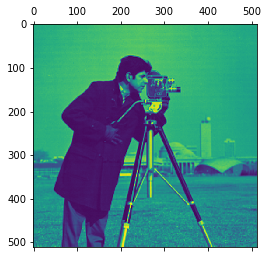

In [18]:
camera = data.camera()
plt.matshow(camera)

In [19]:
camera.shape

(512, 512)

In [20]:
image1 = camera[50:200]
image2 = camera[150:300]
image3 = camera[250:400]

In [42]:
mosaic_12 = ast.stitch(image2, image1, margin = 30)

In [43]:
mosaic_12 = mosaic_12[0]

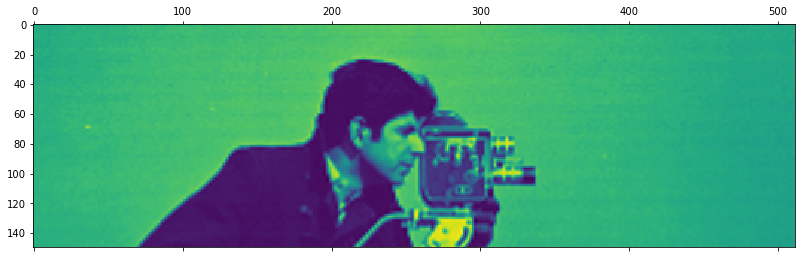

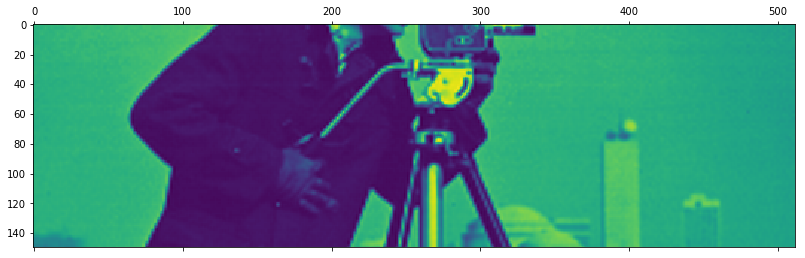

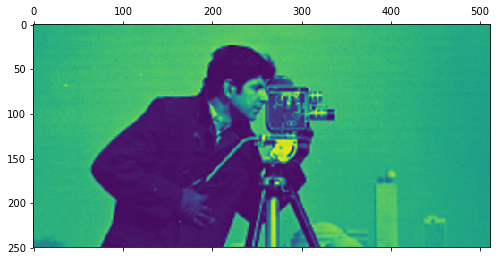

In [45]:
plt.matshow(image1)
plt.matshow(image2)
plt.matshow(mosaic_12)

In [133]:
image1 = (skimage.filters.gaussian(camera, 1)*255).astype('uint8')   
image2 = (skimage.filters.gaussian(camera, 2)*255).astype('uint8')    
image3 = (skimage.filters.gaussian(camera, 3)*255).astype('uint8')    
image4 = (skimage.filters.gaussian(camera, 4)*255).astype('uint8')    
image5 = (skimage.filters.gaussian(camera, 5)*255).astype('uint8')    

In [134]:
list_camera = camera, image1, image2, image3, image4, image5
z_camera = np.dstack(list_camera)

In [137]:
mosaic_12 = ast.stitch(z_camera[150:300,:,4], z_camera[50:200,:,4], margin = 40)

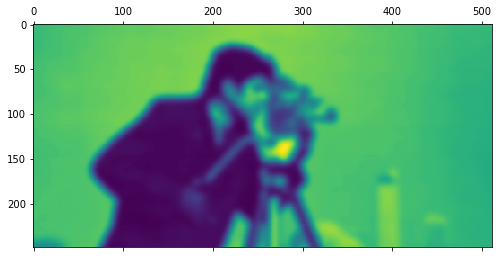

In [138]:
plt.matshow(mosaic_12[0])

In [143]:
mosaic = ast.stitch_zstack(z_camera[150:300,:,:], z_camera[50:200,:,:],1)

../alpenglow/stitching.py:204: UserWarning: I am having trouble finding a good registration. Defaulting to no shift
  warnings.warn("I am having trouble finding a good registration. Defaulting to no shift")


In [144]:
debug

> <ipython-input-139-9c98600595d5>(1)<module>()
----> 1 mosaic = ast.stitch_zstack(z_camera[150:300,:,:], z_camera[50:200,:,:])

ipdb> overlap
*** NameError: name 'overlap' is not defined
ipdb> shift
array([  0.,  15.])
ipdb> coef
*** NameError: name 'coef' is not defined
ipdb> q


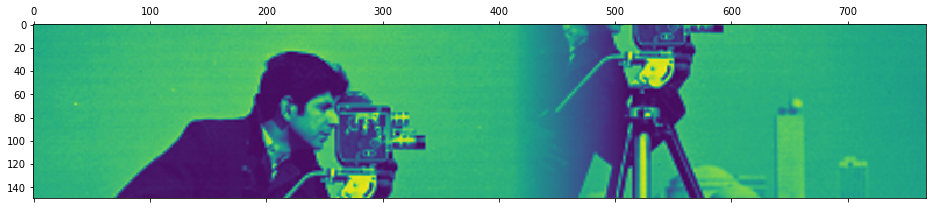

In [142]:
plt.matshow(mosaic[:,:,0])

In [146]:
coeffs = ast.calc_coef(z_camera[150:300,:,:], z_camera[50:200,:,:],1,1)

In [147]:
coeffs

(array([ -1.12,  31.48]), array([[-20.,   0.],
        [-29.,   0.],
        [-56.,   0.],
        [-67.,   0.],
        [-85.,   0.]]))

In [154]:
shift_2 = ast.find_shift(z_camera[150:300,:,2], z_camera[50:200,:,2])
shift_2

array([-25.,   0.])

In [156]:
z_camera.shape

(512, 512, 6)

In [157]:
z_camera = np.memmap(z_camera)

TypeError: Can't convert 'numpy.ndarray' object to str implicitly